## Chapter 6: Feature Selection ##

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
%matplotlib inline

In [2]:
hitters_df = pd.read_csv("../data/Hitters.csv")
hitters_df.dropna(inplace=True)
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Objective is to predict the hitter's salary given other variables. Because this is a regression problem, we first need to convert the non-numeric input variables to factors.

In [3]:
# Converting non-numeric input variables to factors.
hitters_df["League"] = pd.factorize(hitters_df["League"])[0]
hitters_df["Division"] = pd.factorize(hitters_df["Division"])[0]
hitters_df["NewLeague"] = pd.factorize(hitters_df["NewLeague"])[0]
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


In [4]:
# construct a baseline regressor with all features
collist = [col for col in hitters_df.columns if col != "Salary"]
X = hitters_df[collist]
y = hitters_df["Salary"]
reg = LinearRegression()
reg.fit(X, y)
ypred = reg.predict(X)
np.sqrt(mean_squared_error(ypred, y))

//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


303.34447253531619

### Best Subset Regression ###

R's leap package allows for multiple ways to find the best K features for a model - by exhaustive search and forward (greedy) search. Scikit-Learn offers the SelectKBest method to find the best features, presumably using a greedy search.

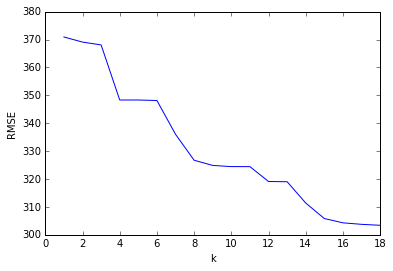

In [5]:
mses = []
nfeatures = range(1, len(collist))
for nfeature in nfeatures:
    # compute MSE for different values of k (top features)
    selector = SelectKBest(f_regression, k=nfeature)
    selector.fit(X, y)
    selected = selector.get_support()
    feats = [col for (col,sel) in zip(collist, selected) if sel]
    reg = LinearRegression()
    X_r = hitters_df[feats]
    reg.fit(X_r, y)
    ypred = reg.predict(X_r)
    mses.append(np.sqrt(mean_squared_error(ypred, y)))
plt.plot(nfeatures, mses)
plt.xlabel("k")
plt.ylabel("RMSE")

### Model Selection by Cross-Validation ###

The RMSE falls as the number of features increase - this is expected because we are computing the RMSE off the training set (overfitting). We will now use 10-fold cross validation on each model to calculate a cross-validation MSE which will give us a better idea of the best feature size to use for the problem.

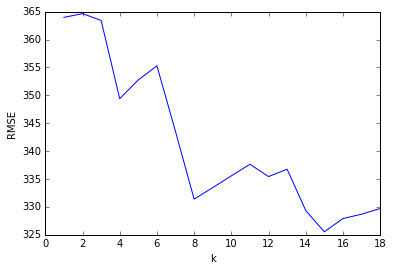

In [6]:
cv_errors = []
kfold = KFold(len(hitters_df), n_folds=10)
nfeatures = range(1, len(collist))
for nfeature in nfeatures:
    # build model with varying number of features
    selector = SelectKBest(f_regression, k=nfeature)
    selector.fit(X, y)
    selected = selector.get_support()
    feats = [col for (col,sel) in zip(collist, selected) if sel]
    X_r = hitters_df[feats].values
    y = hitters_df["Salary"].values
    rmses = []
    for train, test in kfold:
        # each model is cross validated 10 times
        Xtrain, ytrain, Xtest, ytest = X_r[train], y[train], X_r[test], y[test]   
        reg = LinearRegression()
        reg.fit(Xtrain, ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ypred, ytest)))
    cv_errors.append(np.mean(rmses))
plt.plot(nfeatures, cv_errors)
plt.xlabel("k")
plt.ylabel("RMSE")

### Ridge Regression and the Lasso ###

These two methods improve the model by using all features but shrinking the coefficients. Ridge regression uses the L2-norm and Lasso regression uses the L1-norm. Here we use cross validation to compute the RMSE for a baseline model, a model regularized by Ridge regression and one regularized using Lasso.

In [7]:
def cross_validate(X, y, nfolds, reg_name):
    rmses = []
    kfold = KFold(X.shape[0], n_folds=nfolds)
    for train, test in kfold:
        Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]
        reg = None
        if reg_name == "ridge":
            reg = Ridge()
        elif reg_name == "lasso":
            reg = Lasso()
        else:
            reg = LinearRegression()
        reg.fit(Xtrain, ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ytest, ypred)))
    return np.mean(rmses)

collist = [col for col in hitters_df.columns if col != "Salary"]
X = hitters_df[collist].values
y = hitters_df["Salary"].values
rmse_baseline = cross_validate(X, y, 10, "baseline")
rmse_ridge = cross_validate(X, y, 10, "ridge")
rmse_lasso = cross_validate(X, y, 10, "lasso")
(rmse_baseline, rmse_ridge, rmse_lasso)

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


(331.00425667935815, 330.72572506106582, 330.00460161612727)

Finally, we attempt to find an optimum value of alpha for the Lasso regressor using cross-validation.

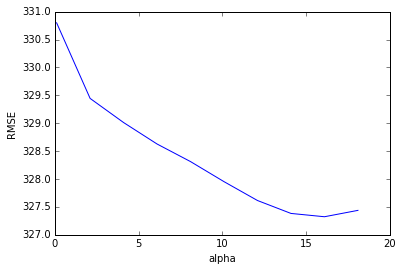

In [8]:
cv_errors = []
alphas = [0.1 * alpha for alpha in range(1, 200, 20)]
kfold = KFold(X.shape[0], n_folds=10)
for alpha in alphas:
    rmses = []
    for train, test in kfold:
        Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]
        reg = Lasso(alpha=alpha)
        reg.fit(Xtrain, ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ytest, ypred)))
    cv_errors.append(np.mean(rmses))
plt.plot(alphas, cv_errors)
plt.xlabel("alpha")
plt.ylabel("RMSE")